# Q2 — Resume Analysis (Pandas Edition, 25 pts)

**Notebook location:** `Quiz1/Q2-code.ipynb`

**Data required:**
- My resume file in `Quiz1/data/resumes/` (e.g., `David_Dinh_Resume_2026WOGPA.pdf`).
- Class resumes in `Quiz1/data/resumes/` (subfolders OK — the code searches recursively).
- Stop-words file at `Quiz1/data/stopwords.txt` (one word per line, lowercase). If missing, a small fallback list is used.



In [1]:
# If needed (first run), install extras then re-run this cell:
# %pip install PyPDF2 python-docx matplotlib pandas --quiet

from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Robust path detection
# -----------------------------
NB_DIR = Path.cwd().resolve()
candidates = [NB_DIR / "data", NB_DIR / "Quiz1" / "data"]
for d in candidates:
    if (d / "stopwords.txt").exists() or (d / "resumes").exists():
        DATA_DIR = d
        break
else:
    DATA_DIR = NB_DIR / "data"  # create local data/ if nothing found
    DATA_DIR.mkdir(parents=True, exist_ok=True)

RESUME_DIR = DATA_DIR / "resumes"
STOP_PATH  = DATA_DIR / "stopwords.txt"
RESUME_DIR.mkdir(parents=True, exist_ok=True)

print("Using DATA_DIR:", DATA_DIR)
print("RESUME_DIR:", RESUME_DIR)
print("STOP_PATH:", STOP_PATH)

# -----------------------------
# Helpers
# -----------------------------
TOKEN = re.compile(r"[A-Za-z']+")

def load_text(path: Path) -> str:
    """Read .txt/.pdf/.docx into a single text string."""
    ext = path.suffix.lower()
    if ext == ".txt":
        return path.read_text(encoding="utf-8", errors="ignore")
    if ext == ".pdf":
        import PyPDF2
        out = []
        with open(path, "rb") as f:
            r = PyPDF2.PdfReader(f)
            for p in r.pages:
                out.append(p.extract_text() or "")
        return "\n".join(out)
    if ext == ".docx":
        import docx
        d = docx.Document(path)
        return "\n".join(para.text for para in d.paragraphs)
    raise ValueError(f"Unsupported file type: {path.name}")

def tokenize(text: str):
    return [w.lower() for w in TOKEN.findall(text or "")]

def words_to_df(words, source=None):
    df = pd.DataFrame({"word": words})
    if source is not None:
        df["source"] = source
    return df

def top_n_df(words, n=20):
    s = pd.Series(words, dtype="string")
    vc = s.value_counts().head(n)
    out = vc.reset_index()
    out.columns = ["word", "count"]
    return out

def plot_top(df_counts, title):
    # df_counts columns: ['word','count']
    plt.figure()
    plt.bar(df_counts['word'], df_counts['count'])
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Stopwords loader (robust)
def load_stopwords(stop_path: Path):
    if stop_path.exists():
        return {w.strip().lower() for w in stop_path.read_text(encoding="utf-8").split() if w.strip()}
    # Minimal fallback (no internet in this environment)

    stop_path.parent.mkdir(parents=True, exist_ok=True)
    return 

stop_words = load_stopwords(STOP_PATH)
print(f"Loaded {len(stop_words)} stop words from {STOP_PATH}")

# Quick path sanity check
print("Sample resumes:", [p.name for p in RESUME_DIR.glob('*')][:5])

Using DATA_DIR: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data
RESUME_DIR: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\resumes
STOP_PATH: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\stopwords.txt
Loaded 127 stop words from C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\stopwords.txt
Sample resumes: ['classmate-resumes', 'David_Dinh_Resume_2026WOGPA.pdf']


## Task 1 — Your resume (10 pts)
Goal: tokenize your resume, show top 20 words (raw) with a table and chart, then remove stop words and show another top 20. Add a short note.

In [2]:
# 1.1 Choose your resume file (edit the filename if needed)
MY_RESUME = RESUME_DIR / "David_Dinh_Resume_2026WOGPA.pdf"  # change if your filename differs
assert MY_RESUME.exists(), f"Can't find your resume at: {MY_RESUME}"
text_me = load_text(MY_RESUME)
resume_words = tokenize(text_me)
len(resume_words), resume_words[:20]

(491,
 ['david',
  'dinh',
  'columbia',
  'south',
  'carolina',
  'wdinh',
  'gmail',
  'com',
  'linkedin',
  'com',
  'in',
  'ddinh',
  'github',
  'com',
  'dd',
  'education',
  'university',
  'of',
  'south',
  'carolina'])

,word,count
0,and,16
1,with,8
2,code,7
3,for,7
4,learning,5
5,of,5
6,data,4
7,software,4
8,aug,4
9,js,4


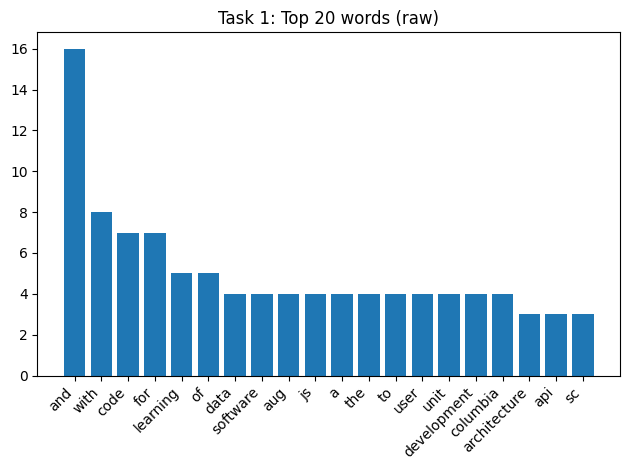

In [3]:
# 1.2 Top-20 (raw) — table + chart
top20_me_raw = top_n_df(resume_words, 20)
display(top20_me_raw)
plot_top(top20_me_raw, "Task 1: Top 20 words (raw)")

# optional save
FIG_DIR = (NB_DIR / "Quiz1" / "figs") if (NB_DIR / "Quiz1").exists() else (NB_DIR / "figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)
top20_me_raw.to_csv(FIG_DIR / "q2_task1_top20_raw.csv", index=False)

,word,count
0,code,7
1,learning,5
2,software,4
3,columbia,4
4,user,4
5,unit,4
6,js,4
7,development,4
8,data,4
9,aug,4


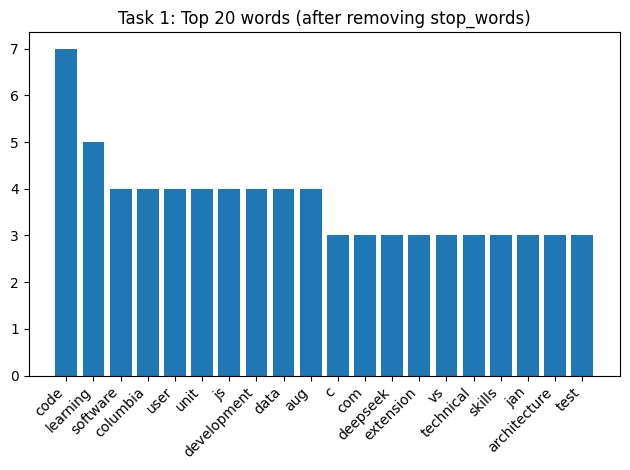

In [4]:
# 1.3 Remove stop-words and re-run top-20
me_specific = [w for w in resume_words if w not in stop_words]
top20_me_specific = top_n_df(me_specific, 20)
display(top20_me_specific)
plot_top(top20_me_specific, "Task 1: Top 20 words (after removing stop_words)")
top20_me_specific.to_csv(FIG_DIR / "q2_task1_top20_specific.csv", index=False)

**Short note (replace this with your own):**
- New words that surfaced after filtering: `...`
- Why this is more representative: `...`

## Task 2 — Class resumes (10 pts)
Goal: aggregate all resumes in the folder (recursively), show top 20 (raw), then after removing stop-words; add a short note about the class profile.

In [5]:
# 2.1 Load every file from the resumes folder (recursively)
all_words = []
skipped = []
for f in RESUME_DIR.rglob('*'):
    if f.is_file() and f.suffix.lower() in {'.txt', '.pdf', '.docx'}:
        try:
            all_words.extend(tokenize(load_text(f)))
        except Exception as e:
            skipped.append((f.name, str(e)))
len(all_words), skipped[:5]

(11886, [])

,word,count
0,and,481
1,to,226
2,of,203
3,a,184
4,in,170
5,the,140
6,for,135
7,with,119
8,data,88
9,sc,88


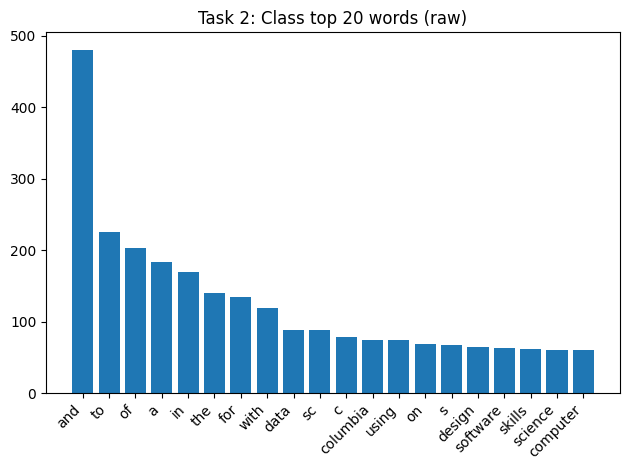

In [6]:
# 2.2 Top-20 for the class (raw)
top20_class_raw = top_n_df(all_words, 20)
display(top20_class_raw)
plot_top(top20_class_raw, "Task 2: Class top 20 words (raw)")
top20_class_raw.to_csv(FIG_DIR / "q2_task2_top20_raw.csv", index=False)

,word,count
0,sc,88
1,data,88
2,c,79
3,columbia,74
4,using,74
5,design,65
6,software,63
7,skills,61
8,computer,60
9,science,60


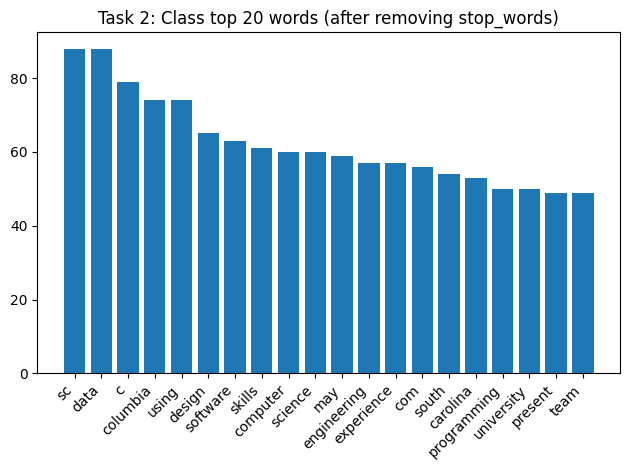

In [7]:
# 2.3 After removing stop-words
class_specific_words = [w for w in all_words if w not in stop_words]
top20_class_specific = top_n_df(class_specific_words, 20)
display(top20_class_specific)
plot_top(top20_class_specific, "Task 2: Class top 20 words (after removing stop_words)")
top20_class_specific.to_csv(FIG_DIR / "q2_task2_top20_specific.csv", index=False)

**Short note (replace this with your own):**
- Words that characterize the class: `...`
- Did filtering help reveal a clearer profile? `...`

## Task 3 — Unique-to-me words (5 pts)
Goal: find words unique to *your* resume vs. the class by comparing your `me_specific` with the class set.

In [8]:
# 3.1 Compare with class top specific words
class_top_specific = set(top20_class_specific['word'].tolist())  # compare against frequent class words
unique_to_me = sorted(set(me_specific) - class_top_specific)
unique_df = pd.DataFrame({"word": unique_to_me})
display(unique_df.head(30))
unique_df.to_csv(FIG_DIR / "q2_task3_unique_to_me.csv", index=False)

,word
0,aa
1,accessibility
2,accuracy
3,actionable
4,advancement
5,agile
6,ai
7,algorithms
8,angular
9,anywhere


**Short note**
- Words that I found Unique, was bugs, I know we face alot of it but looking through these resumes, alot of students interact with coding bugs. 

In [9]:
# Final quick checks
print("stopwords path:", STOP_PATH.resolve(), STOP_PATH.exists())
print("resumes dir:", RESUME_DIR.resolve(), RESUME_DIR.exists())
print("sample resumes:", [p.name for p in RESUME_DIR.glob('*')][:5])

stopwords path: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\stopwords.txt True
resumes dir: C:\Users\wdinh\4-Module-Sequence-for-Applied-Deep-Learning\Quiz1\data\resumes True
sample resumes: ['classmate-resumes', 'David_Dinh_Resume_2026WOGPA.pdf']
